In [5]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import random

In [6]:
#RANDOM FOREST REGRESSOR MODEL
dataset = pd.read_csv('hdfc_updated.csv')
dataset = dataset.dropna()
dataset = dataset[['Open', 'High', 'Low', 'Close']]

dataset['Date'] = range(1, len(dataset) + 1)

dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']

#3-day moving average
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()

#10 day moving average
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()

#30 day moving average
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()

#Standard deviation
dataset['Std_dev']= dataset['Close'].rolling(5).std()

#Relative Strength Index
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)

#Williams %R
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) - dataset['Close'], 1, 0)
dataset = dataset.dropna()

X = dataset.iloc[:, 4:-1]
y = dataset.iloc[:, 0]

split = int(len(dataset)*0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
print(X_train.columns)

Index(['Date', 'H-L', 'O-C', '3day MA', '10day MA', '30day MA', 'Std_dev',
       'RSI', 'Williams %R'],
      dtype='object')


In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train[['H-L', 'O-C', '3day MA', '10day MA', '30day MA', 'Std_dev',
       'RSI', 'Williams %R']] = sc.fit_transform(X_train[['H-L', 'O-C', '3day MA', '10day MA', '30day MA', 'Std_dev',
              'RSI', 'Williams %R']])
X_test[['H-L', 'O-C', '3day MA', '10day MA', '30day MA', 'Std_dev',
       'RSI', 'Williams %R']] = sc.fit_transform(X_test[['H-L', 'O-C', '3day MA', '10day MA', '30day MA', 'Std_dev',
              'RSI', 'Williams %R']])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

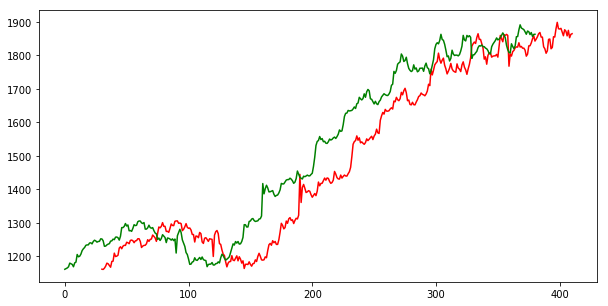

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_train, color='r')
plt.plot(y_train_pred, color='g')
plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(np.array(y_test), color='r')
# plt.plot(np.array(y_pred), color='g')
# plt.show()

In [3]:
#HOLT_WINTER_MODEL
def holt_winter_model(path, s_param):
    df = pd.read_csv(path)
    df.head()
    
    df = df[['Date', 'Close']]
    df.dropna()
    df.head()
    
    split = int(len(df)-40)
    train = df[:split]
    test = df[split:]
    
    df.Timestamp = pd.to_datetime(df.Date,format='%Y-%m-%d') 
    df.index = df.Timestamp 
    df = df.resample('D').mean()
    train.Timestamp = pd.to_datetime(train.Date,format='%Y-%m-%d') 
    train.index = train.Timestamp 
    train = train.resample('D').mean() 
    test.Timestamp = pd.to_datetime(test.Date,format='%Y-%m-%d') 
    test.index = test.Timestamp 
    test = test.resample('D').mean()
    
    train = train[np.isfinite(train['Close'])]
    test = test[np.isfinite(test['Close'])]
    #train.Close.plot(title= 'Closing price', fontsize=14)
    #test.Close.plot(title= 'Closing price', fontsize=14)
    
    from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
    y_hat_avg = test.copy()
    fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=s_param ,trend='add', seasonal='add',).fit()
    y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
    
    plt.figure(figsize=(16,8))
    plt.plot( train['Close'], label='Train')
    plt.plot(test['Close'], label='Test')
    plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
    plt.legend(loc='best')
    plt.show()
    
    #print(y_hat_avg)
    arr = np.array(y_hat_avg)
    arr[29][1]
    
    net_return = (arr[29][1] - arr[0][1])/arr[0][1]*100
    return net_return

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


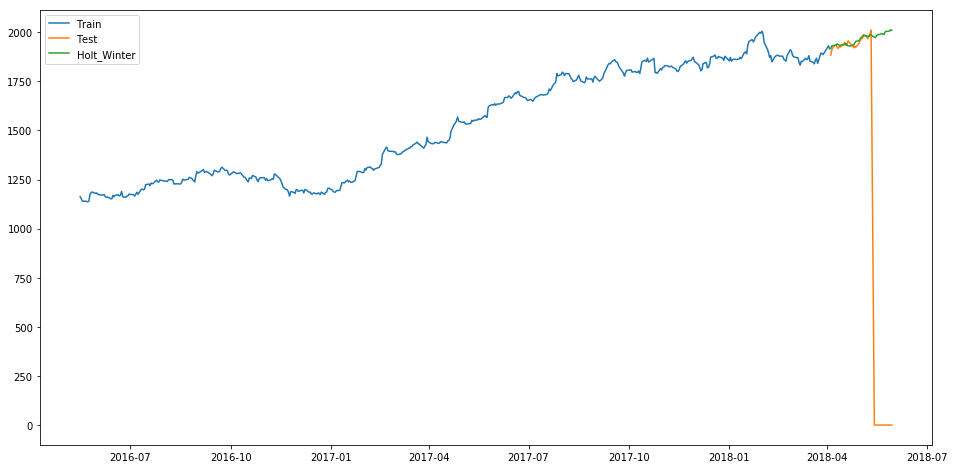

3.472866948782859


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


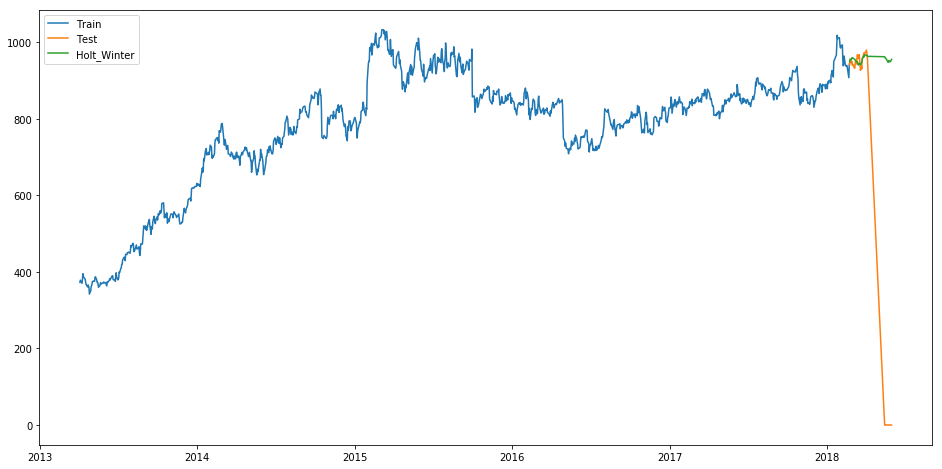

0.9570180079120629


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


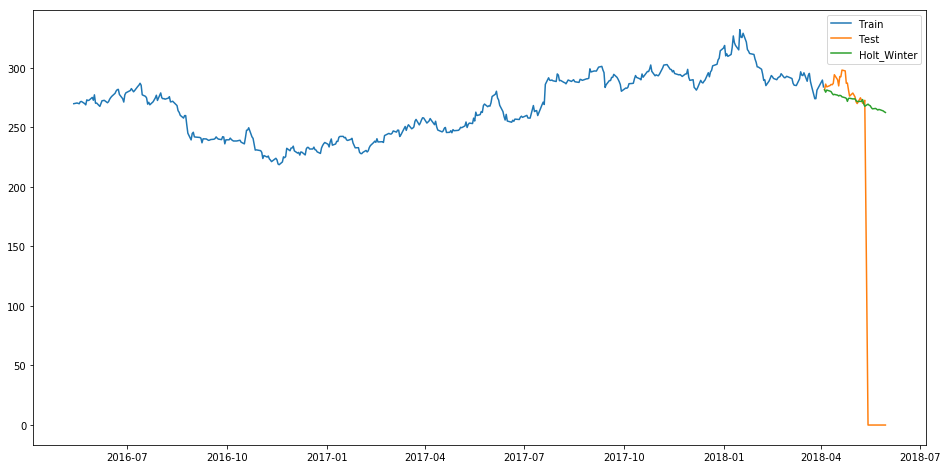

-4.750682119674001


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


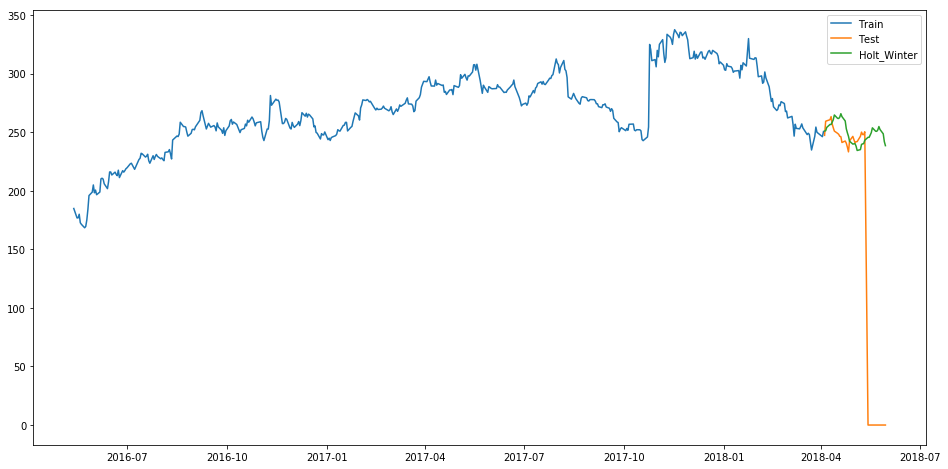

-1.3694251346028867


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


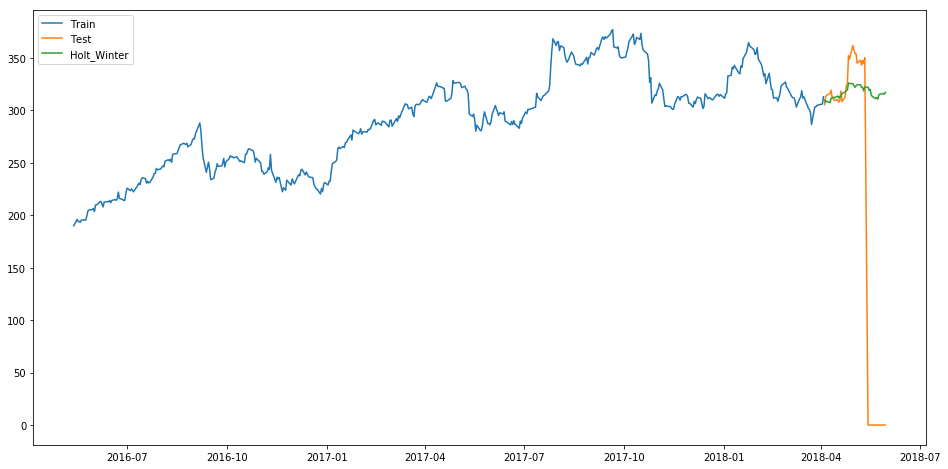

3.2936605986947045


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


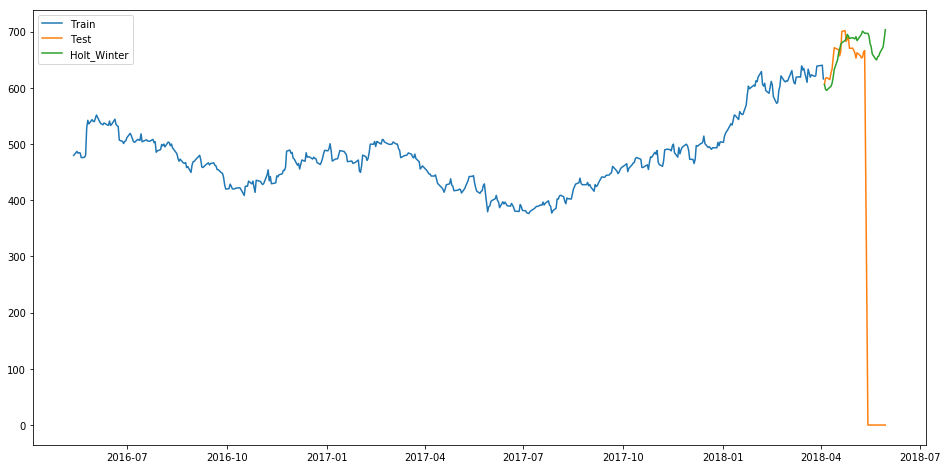

11.976573127137186


In [4]:
print(holt_winter_model('hdfcFINAL.csv', 34))
print(holt_winter_model('HCLTECH.NS.csv', 20))
print(holt_winter_model('WIPRO.NS.csv', 25))
print(holt_winter_model('SBIN.NS.csv', 24))
print(holt_winter_model('YESBANK.NS.csv', 31))
print(holt_winter_model('TECHM.NS.csv', 31))

## LSTM MODEL

In [9]:
sbi = pd.read_csv("SBIN.NS.csv")
sbi.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-13,187.949997,187.949997,184.300003,184.850006,180.818314,15546644
1,2016-05-16,185.000000,185.000000,175.149994,176.800003,172.943878,30937008
2,2016-05-17,178.500000,178.600006,175.250000,176.850006,172.992798,22183140
3,2016-05-18,176.899994,180.449997,173.550003,179.949997,176.025177,25345278
4,2016-05-19,181.000000,181.000000,171.899994,172.699997,168.933289,25480517


In [10]:
sbi = sbi.dropna()
sbi
sbi_main = sbi['Close'].values

In [11]:
scaler = StandardScaler()
sbi_main = scaler.fit_transform(sbi_main.reshape(-1, 1))

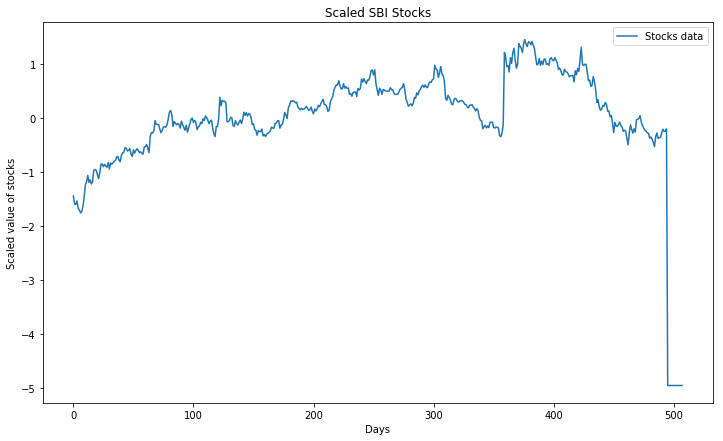

In [12]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled SBI Stocks')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(sbi_main, label='Stocks data')
plt.legend()
plt.show()

In [13]:
def window_data(data, window_size):
    '''
    This function is used to create Features and Labels datasets. By windowing the data.
    
    Input: data - dataset used in the project
           window_size - how many data points we are going to use to predict the next datapoint in the sequence 
                       [Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
    
    Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
             y - 'labels', actually this is the next number in the sequence, this number we are trying to predict
    '''
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [14]:
X, y = window_data(sbi_main, 7)

In [15]:
X_train  = np.array(X[:400])
y_train = np.array(y[:400])

X_test = np.array(X[400:])
y_test = np.array(y[400:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (400, 7, 1)
y_train size: (400, 1)
X_test size: (101, 7, 1)
y_test size: (101, 1)


In [25]:
#Hyperparameters used in the network#Hyperpa 
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 60

In [17]:
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [18]:
# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

In [19]:
## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [20]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [21]:
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [22]:
outputs

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [23]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

In [24]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

# Time to train

In [26]:
session = tf.Session()

In [27]:
session.run(tf.global_variables_initializer())

In [28]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/60  Current loss: 0.1782902479171753
Epoch 30/60  Current loss: 0.013146704062819481


In [29]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [30]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [31]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [32]:
test_results = []
for i in range(499):
    if i >= 401:
        test_results.append(scaler.inverse_transform(tests_new[i-401]))
    else:
        test_results.append(None)

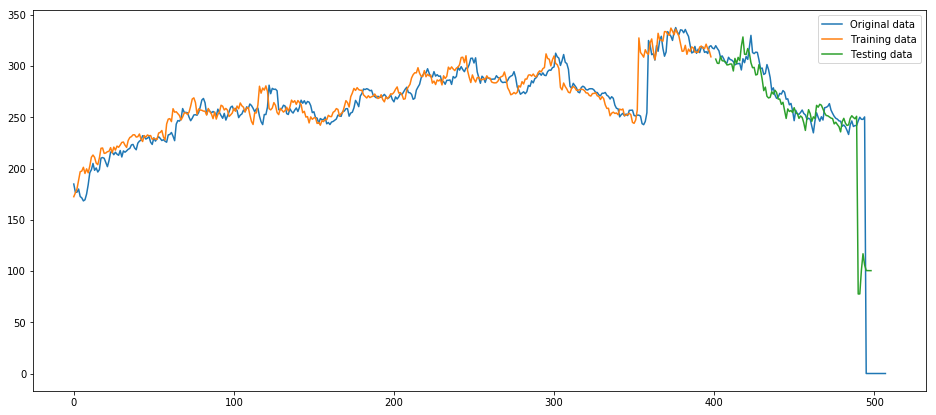

In [33]:
plt.figure(figsize=(16, 7))
plt.plot(scaler.inverse_transform(sbi_main), label='Original data')
plt.plot(scaler.inverse_transform(sup), label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()